In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [4]:
def factor(df, lambda_val=0.4, window_size=20*96):
    """
    计算理想换手率因子 T(λ) = T_high(λ) - T_low(λ)
    
    步骤:
    1. 使用成交量作为换手率代理
    2. 滚动窗口计算(窗口大小=20天=20*96根15分钟线)
    3. 在每个窗口内:
        - 按收盘价排序
        - 取高价区(收盘价最高的前λ比例)
        - 取低价区(收盘价最低的前λ比例)
        - 分别计算高价区和低价区的成交量均值
    4. 理想换手率因子 = 高价区成交量均值 - 低价区成交量均值
    
    参数:
    df: 包含OHLCV数据的DataFrame
    lambda_val: 切割比例(默认0.4)
    window_size: 滚动窗口大小(默认20天=1920根15分钟线)
    """
    volume = df['volume']
    
    # 初始化结果Series
    ideal_vol = pd.Series(index=df.index, dtype=float)
    
    # 滚动窗口计算
    for i in range(window_size, len(df)):
        window_data = df.iloc[i-window_size:i]
        window_vol = volume.iloc[i-window_size:i]
        
        # 按收盘价排序
        sorted_indices = window_data['close'].argsort()
        sorted_vol = window_vol.iloc[sorted_indices]
        
        # 确定切割位置
        n = len(window_data)
        n_low = int(n * lambda_val)
        n_high = int(n * lambda_val)
        
        # 计算低价区成交量均值
        low_vol_mean = sorted_vol.iloc[:n_low].mean()
        
        # 计算高价区成交量均值
        high_vol_mean = sorted_vol.iloc[-n_high:].mean()
        
        # 计算理想换手率因子
        ideal_vol.iloc[i] = high_vol_mean - low_vol_mean
    
    return ideal_vol

# 测试因子表现


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): -0.004256
   Rank_IC (Spearman): 0.003150
📊 信息比率:
   IR: -0.606097
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 129115
   因子列: factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


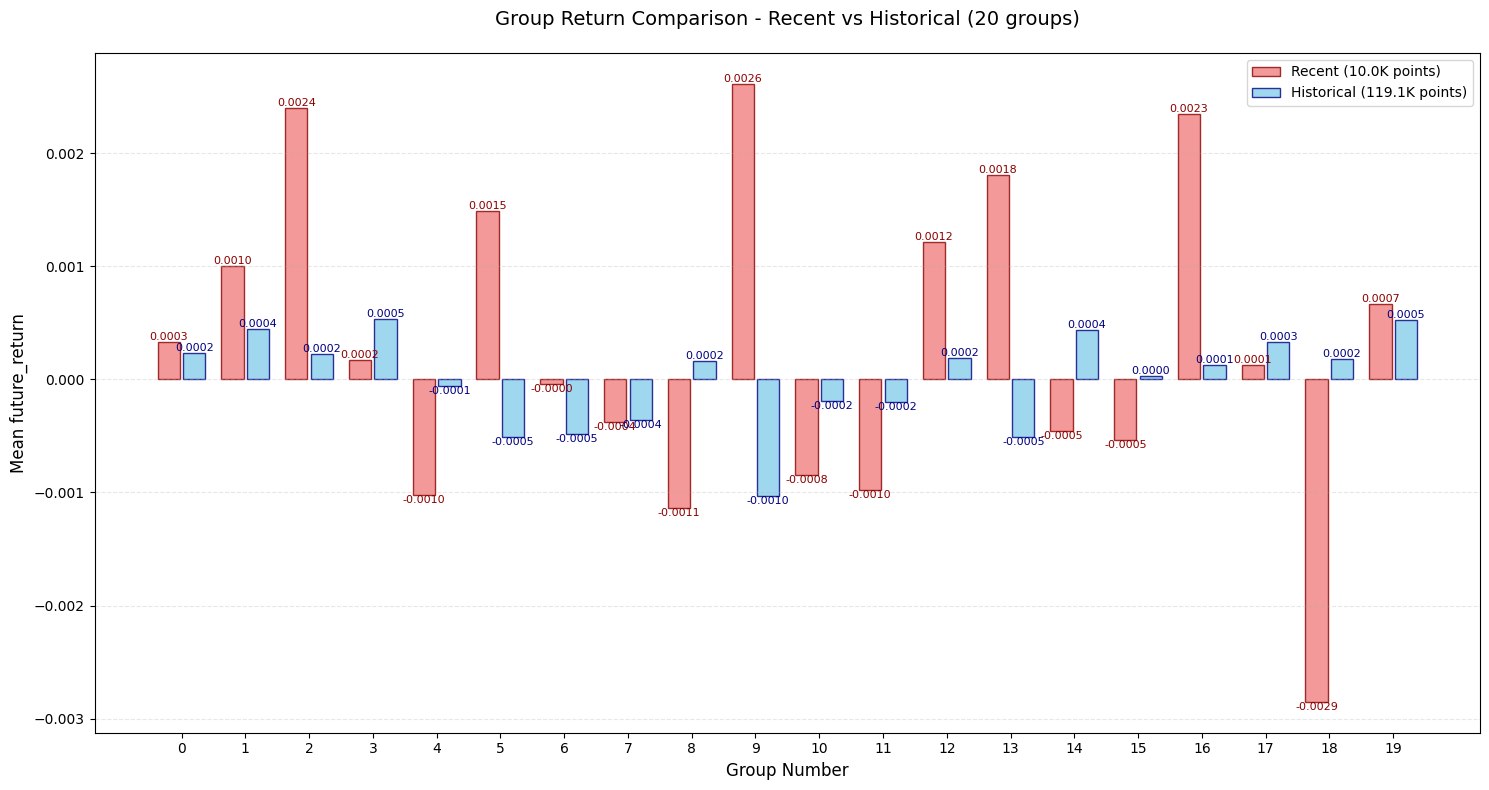

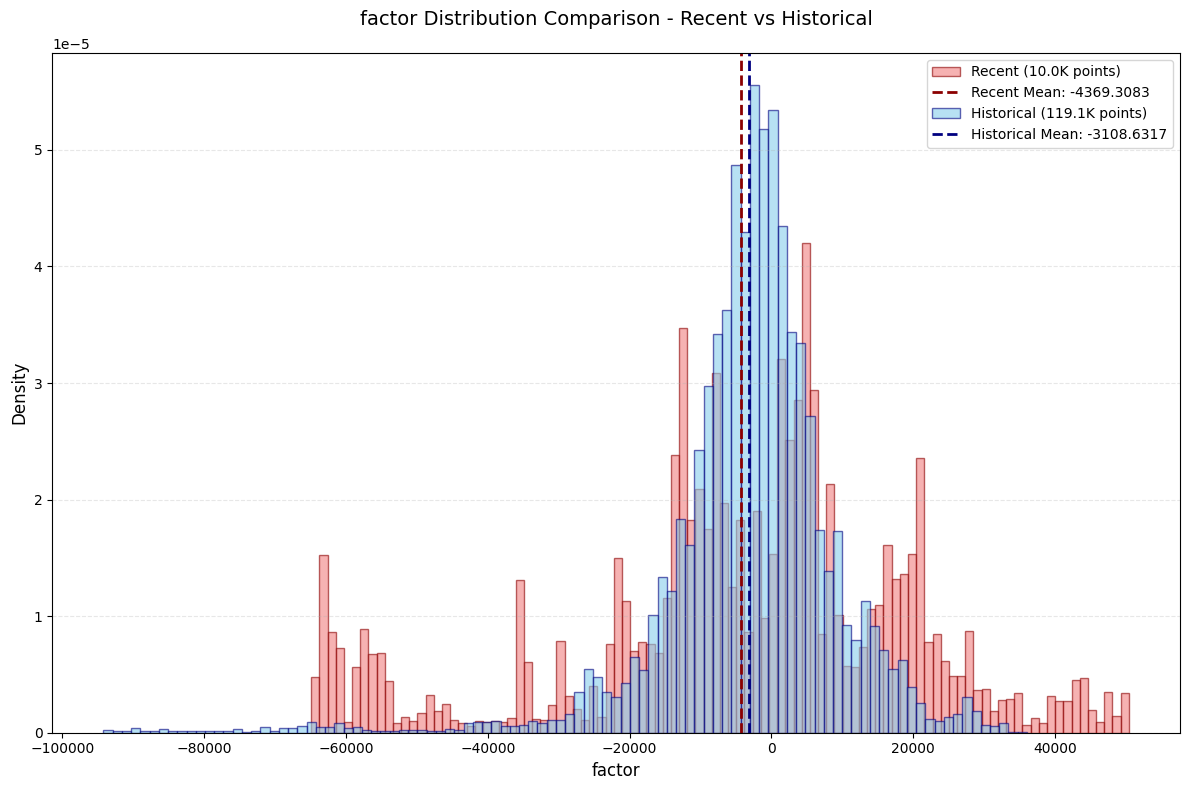

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [5]:
evaluator.set_factor(
    factor_func=lambda df: factor(df),
    factor_name='factor'
)

result=evaluator.run_full_evaluation(run_stationarity_test=False)

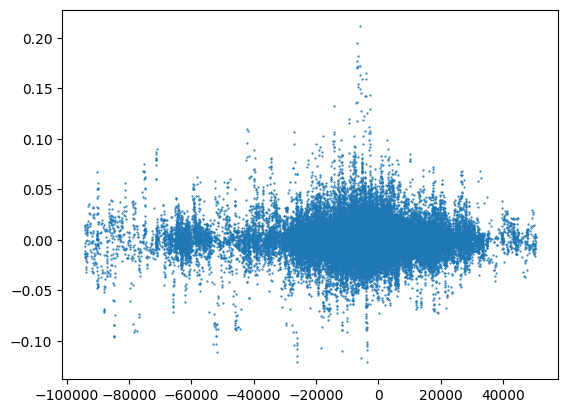

In [6]:
import matplotlib.pyplot as plt
plt.scatter(factor(df),df['close'].pct_change(-10), s=0.3)

In [7]:
result['information_ratio']['group_correlations']
# 这表示不同分组之间的相关性，通常用于评估因子在不同市场状态下的表现一致性。
# 如果相关性较高，说明因子在不同市场状态下表现一致；如果相关性较低，说明因子在不同市场状态下表现差异较大。

[-0.010701812225122193,
 -0.019268468179568805,
 -0.03841447558643465,
 -0.013914660373335972,
 -0.04582873049671207,
 0.014542708568345615,
 0.01824552957152087,
 -0.0072379419883121295,
 2.03234298066298e-05,
 -0.013852719121477354]

In [8]:
print(result)

{'correlation_analysis': {'IC': -0.004255568050719544, 'Rank_IC': 0.0031496216339004643}, 'information_ratio': {'IR': -0.6060973807543402, 'group_correlations': [-0.010701812225122193, -0.019268468179568805, -0.03841447558643465, -0.013914660373335972, -0.04582873049671207, 0.014542708568345615, 0.01824552957152087, -0.0072379419883121295, 2.03234298066298e-05, -0.013852719121477354], 'n_groups': 10}, 'group_analysis': {'group_stats':           val_min     val_max    val_mean  return_mean  return_std  count
group                                                                    
0     -94214.2762 -24925.9961 -44604.9297       0.0002      0.0190   6456
1     -24924.9552 -16038.2886 -19709.5918       0.0004      0.0151   6456
2     -16038.1141 -12525.1865 -14146.4437       0.0007      0.0132   6479
3     -12524.9406 -10066.3275 -11232.2521       0.0003      0.0134   6432
4     -10066.0775  -8221.1416  -9059.0529       0.0002      0.0116   6456
5      -8221.0815  -6759.6736  -7469.0341  